# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
from scipy.optimize import root

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

In [ ]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data/'

### Perform some basic filtering

In [ ]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [ ]:
def simplify_name(name):
    return name.split('.')[0]

In [ ]:
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

In [ ]:
adata.obs.cell.value_counts()

In [ ]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

In [ ]:
sc.pl.tsne(adata, color='cell_type')

In [ ]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [ ]:
print('Number of genes kept:', adata.shape[1])

### Null distributions

In [ ]:
imp.reload(scmemo)
imp.reload(bootstrap)
imp.reload(hypothesis_test)
imp.reload(util)

test_adata = adata[adata.obs.cell == 'B cells'].copy()
test_adata.obs['stim'] = np.random.choice(test_adata.obs['stim'], test_adata.shape[0])
scmemo.create_groups(test_adata, label_columns=['stim'], inplace=True)
scmemo.compute_1d_moments(
    test_adata, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=True, filter_mean_thresh=0.1, 
    min_perc_group=0.9)
print('Number of genes kept:{}'.format(test_adata.shape[1]))

In [140]:
size_factor = test_adata.uns['scmemo']['all_size_factor']
# binned_stat = stats.binned_statistic(size_factor, size_factor, bins=50, statistic='mean')
# bin_idx = np.clip(binned_stat[2], a_min=1, a_max=binned_stat[0].shape[0])
# approx_sf = binned_stat[0][bin_idx-1]
# max_sf = size_factor.max()
# approx_sf[size_factor == max_sf] = max_sf
# test_adata.uns['scmemo']['all_size_factor'] = approx_sf
# # size_factor = approx_sf

In [141]:
a = 0.1
b = 1.7

In [142]:
actual_moments_1 = estimator._poisson_1d(
    test_adata[(test_adata.obs['stim'] == 'ctrl').values].X,
    (test_adata.obs['stim'] == 'ctrl').values.shape[0],
    size_factor[(test_adata.obs['stim'] == 'ctrl').values]
    )
actual_rv_1 = actual_moments_1[1]/(a*actual_moments_1[0]**(b))

actual_moments_2 = estimator._poisson_1d(
    test_adata[(test_adata.obs['stim'] == 'stim').values].X,
    (test_adata.obs['stim'] == 'stim').values.shape[0],
    size_factor[(test_adata.obs['stim'] == 'stim').values]
    )
actual_rv_2 = actual_moments_2[1]/(a*actual_moments_2[0]**(b))

overall_moments = estimator._poisson_1d(
    test_adata.X,
    test_adata.shape[0],
    size_factor)
overall_rv = overall_moments[1]/(a*overall_moments[0]**(b))

# Actual size factors
sf_1 = size_factor[(test_adata.obs['stim'] == 'ctrl').values].reshape(-1, 1)
sf_2 = size_factor[(test_adata.obs['stim'] == 'stim').values].reshape(-1, 1)

In [143]:
def _sparse_broadcast_row(mat, vec):
    """ Multiply each row of mat with vec elementwise. """
    
    return mat*sp.sparse.spdiags(vec, 0, vec.shape[0], vec.shape[0])

def _sparse_broadcast_col(mat, vec):
    """ Multiply each row of mat with vec elementwise. """
    
    return sp.sparse.spdiags(vec, 0, vec.shape[0], vec.shape[0])*mat

def _compute_constants(mat, sf):
    
    alpha = _sparse_broadcast_col(mat.power(2), 1/sf**2).mean(axis=0).A1
    beta = _sparse_broadcast_col(mat, 1/sf**2).mean(axis=0).A1
    delta = _sparse_broadcast_col(mat, 1/sf).mean(axis=0).A1

    return alpha, beta, delta
    
def _find_rv_factor(rv_to_match, alpha, beta, delta, a, b):
    
    init = (rv_to_match*a + beta/delta)/(alpha/delta - delta)
    factor = np.array([root(lambda x: (alpha[idx]*x**2 - beta[idx]*x - delta[idx]**2*x**2)/(a*delta[idx]**b*x**b) - rv_to_match[idx], init[idx]).x[0] for idx in range(rv_to_match.shape[0])])
    factor[np.isnan(factor)] = init[np.isnan(factor)]
    
    return factor

def _match_rv(mat, sf, rv_to_match, a, b):
    """ Assumes :mat: is a sparse matrix. """
    
    sf = sf.reshape(-1)
    
    alpha, beta, delta = _compute_constants(mat, sf)
    factors = _find_rv_factor(rv_to_match, alpha, beta, delta, a, b)
    
    return _sparse_broadcast_row(mat, factors)

In [132]:
rv_matched_mat_1 = _match_rv(
    mat=test_adata[(test_adata.obs['stim'] == 'ctrl').values].X,
    sf=sf_1,
    rv_to_match=overall_rv,
    a=0.1,
    b=1.7)
transf_moments_1 = estimator._poisson_1d(
    rv_matched_mat_1,
    rv_matched_mat_1.shape[0],
    sf_1)
transf_rv_1 = transf_moments_1[1]/(0.1*transf_moments_1[0]**1.7)
print(transf_rv_1[:5])
print(overall_rv[:5])

[22.87423806  5.6323692   3.05080979 -0.56241485  2.03890674]
[22.87423806  5.6323692   3.05080979 -0.56241485  2.03890674]


(0, 500)

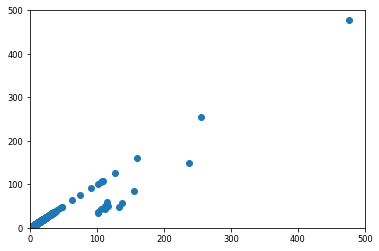

In [40]:
plt.scatter(transf_rv_1, overall_rv)
plt.xlim(0, 500); plt.ylim(0, 500)

In [41]:
rv_matched_mat_2 = _match_rv(
    mat=test_adata[(test_adata.obs['stim'] == 'stim').values].X,
    sf=sf_2,
    rv_to_match=overall_rv,
    a=0.1,
    b=1.7)
transf_moments_2 = estimator._poisson_1d(
    rv_matched_mat_2,
    rv_matched_mat_2.shape[0],
    sf_2)
transf_rv_2 = transf_moments_2[1]/(0.1*transf_moments_2[0]**1.7)
print(transf_rv_2[:5])
print(overall_rv[:5])

[22.87423806  5.6323692   3.05080979 -0.56241485  2.03890674]
[22.87423806  5.6323692   3.05080979 -0.56241485  2.03890674]


In [42]:
%%time
# Generate the null distribution
num_boot = 100
moments_1, moments_2 = [], []
cell_count_1, cell_count_2 = [], []
transformed_mat = sp.sparse.vstack([rv_matched_mat_1, rv_matched_mat_2])
transformed_label = pd.Series(['ctrl' for i in range(rv_matched_mat_1.shape[0])] + ['stim' for i in range(rv_matched_mat_2.shape[0])])
transformed_size_factors = np.concatenate([sf_1, sf_2])

for boot_trial in range(num_boot):
    
    boot_idxs = np.random.choice(test_adata.shape[0], test_adata.shape[0])
    
    boot_mat = transformed_mat[boot_idxs, :]
    boot_label = transformed_label[boot_idxs]
    boot_size_factors = transformed_size_factors[boot_idxs]
#     size_factors = approx_sf
    
    boot_idxs_1 = (boot_label == 'ctrl').values
    boot_idxs_2 = (boot_label == 'stim').values
    
    moments_1.append(
        estimator._poisson_1d(
            boot_mat[boot_idxs_1],
            boot_idxs_1.shape[0],
            boot_size_factors[boot_idxs_1])
    )
    moments_2.append(
        estimator._poisson_1d(
            boot_mat[boot_idxs_2],
            boot_idxs_2.shape[0],
            boot_size_factors[boot_idxs_2])
    )
    cell_count_1.append(boot_idxs_1.shape[0])
    cell_count_2.append(boot_idxs_2.shape[0])
    

CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 1.07 s


In [51]:
rvs_1, rvs_2 = [], []
for boot_trial in range(num_boot):
    
    rvs_1.append(moments_1[boot_trial][1]/(a*moments_1[boot_trial][0]**b))
    rvs_2.append(moments_2[boot_trial][1]/(a*moments_2[boot_trial][0]**b))
    
to_add = 0
rvs_1, rvs_2 = np.array(rvs_1)+to_add, np.array(rvs_2)+to_add

actual_rvs_ratio = (actual_rv_2+to_add)/(actual_rv_1+to_add)

null_rvs_ratio = rvs_2/rvs_1
null_rvs_ratio -= null_rvs_ratio.mean(axis=0) - 1

one_sided = np.nansum(null_rvs_ratio > actual_rvs_ratio, axis=0)/np.isfinite(null_rvs_ratio).sum(axis=0)
rv_pval = 2*np.minimum(1-one_sided, one_sided)

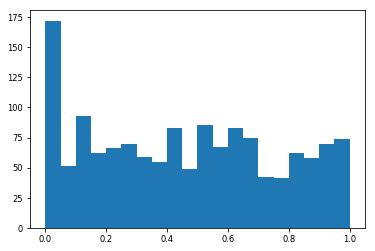

In [52]:
plt.hist(rv_pval, bins=20);

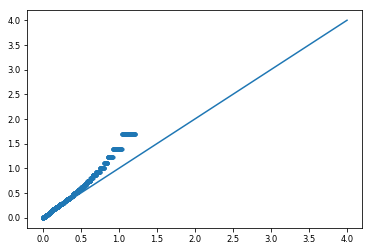

In [53]:
x = np.sort(rv_pval)

plt.scatter(
    -np.log10(np.linspace(0, 1, x.shape[0])), 
    -np.log10(x), s=10)

plt.plot([0, 4], [0, 4])

In [144]:
%%time

num_boot = 100
moments_1, moments_2 = [], []
cell_count_1, cell_count_2 = [], []

for boot_trial in range(num_boot):
    boot_idxs = np.random.choice(test_adata.shape[0], test_adata.shape[0])
    
    boot_mat = test_adata.X[boot_idxs, :]
    boot_label = test_adata.obs['stim'][boot_idxs]
    size_factors = test_adata.uns['scmemo']['all_size_factor'][boot_idxs]
#     size_factors = approx_sf
    
    boot_idxs_1 = (boot_label == 'ctrl').values
    boot_idxs_2 = (boot_label == 'stim').values
    
    moments_1.append(
        estimator._poisson_1d(
            boot_mat[boot_idxs_1],
            boot_idxs_1.shape[0],
            size_factors[boot_idxs_1])
    )
    moments_2.append(
        estimator._poisson_1d(
            boot_mat[boot_idxs_2],
            boot_idxs_2.shape[0],
            size_factors[boot_idxs_2])
    )
    cell_count_1.append(boot_idxs_1.shape[0])
    cell_count_2.append(boot_idxs_2.shape[0])
    

CPU times: user 1.38 s, sys: 6.62 ms, total: 1.38 s
Wall time: 1.38 s


In [ ]:
means_1, vars_1, means_2, vars_2, rvs_1, rvs_2 = [],[],[],[], [], []
for boot_trial in range(num_boot):
    
    means_1.append(moments_1[boot_trial][0])
    vars_1.append(moments_1[boot_trial][1])

    means_2.append(moments_2[boot_trial][0])
    vars_2.append(moments_2[boot_trial][1])
    
    rvs_1.append(moments_1[boot_trial][1]/(a*moments_1[boot_trial][0]**b))
    rvs_2.append(moments_2[boot_trial][1]/(a*moments_2[boot_trial][0]**b))

means_1, vars_1, means_2, vars_2 = np.array(means_1), np.array(vars_1), np.array(means_2), np.array(vars_2)

rvs_1, rvs_2 = np.array(rvs_1), np.array(rvs_2)

actual_rv_ratio = actual_rv_2/actual_rv_1
boot_rv_ratio = rvs_2/rvs_1

centered = boot_rv_ratio/boot_rv_ratio.std(axis=0)
c = (centered > actual_rv_ratio).mean(axis=0)
pvals = 2*np.minimum(c, 1-c)


In [ ]:
plt.hist(pvals)

In [61]:
means_1, vars_1, means_2, vars_2, rvs_1, rvs_2 = [],[],[],[], [], []
for boot_trial in range(num_boot):
    
    means_1.append(moments_1[boot_trial][0])
    vars_1.append(moments_1[boot_trial][1])

    means_2.append(moments_2[boot_trial][0])
    vars_2.append(moments_2[boot_trial][1])
    
    rvs_1.append(moments_1[boot_trial][1]/(a*moments_1[boot_trial][0]**b))
    rvs_2.append(moments_2[boot_trial][1]/(a*moments_2[boot_trial][0]**b))

means_1, vars_1, means_2, vars_2 = np.array(means_1), np.array(vars_1), np.array(means_2), np.array(vars_2)

rvs_1, rvs_2 = np.array(rvs_1), np.array(rvs_2)

var_add = 10

# vars_1 += var_add
# vars_2 += var_add

actual_mean_diff = actual_moments_2[0] - actual_moments_1[0] 
actual_var_diff = np.log((actual_moments_2[1])/actual_moments_2[0]+1) - np.log((actual_moments_1[1])/actual_moments_1[0]+1)
actual_rv_diff = 

# means_1 -= actual_moments_1[0]
# means_2 -= actual_moments_2[0]
# vars_1 -= actual_moments_1[1]
# vars_2 -= actual_moments_2[1]

mean_diff = means_2 - means_1
mean_diff -= actual_mean_diff

var_diff = np.log((vars_2)/means_2+1) - np.log((vars_1)/means_1+1)
var_diff -= actual_var_diff

mean_pval = 2*np.minimum(1-(mean_diff > (actual_mean_diff)).mean(axis=0), (mean_diff > (actual_mean_diff)).mean(axis=0))
var_pval = 2*np.minimum(1-(var_diff > (actual_var_diff)).mean(axis=0), (var_diff > (actual_var_diff)).mean(axis=0))

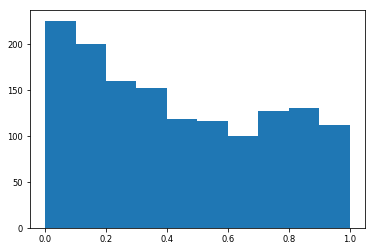

In [62]:
plt.hist(var_pval, bins=10);

In [393]:
means_1, vars_1, means_2, vars_2 = [],[],[],[]
for boot_trial in range(num_boot):
    
    means_1.append(moments_1[boot_trial][0])
    vars_1.append(moments_1[boot_trial][1])

    means_2.append(moments_2[boot_trial][0])
    vars_2.append(moments_2[boot_trial][1])
    
means_1, vars_1, means_2, vars_2 = np.array(means_1), np.array(vars_1), np.array(means_2), np.array(vars_2)

var_add = 100

vars_1 += var_add
vars_2 += var_add

actual_mean_diff = actual_moments_2[0] - actual_moments_1[0] 
actual_var_diff = np.log((actual_moments_2[1]+var_add)/actual_moments_2[0]) - np.log((actual_moments_1[1]+var_add)/actual_moments_1[0])

# means_1 -= actual_moments_1[0]
# means_2 -= actual_moments_2[0]
# vars_1 -= actual_moments_1[1]
# vars_2 -= actual_moments_2[1]

mean_diff = means_2 - means_1
mean_diff -= actual_mean_diff

var_diff = np.log((vars_2)/means_2) - np.log((vars_1)/means_1)
var_diff -= actual_var_diff

mean_pval = 2*np.minimum(1-(mean_diff > (actual_mean_diff)).mean(axis=0), (mean_diff > (actual_mean_diff)).mean(axis=0))
var_pval = 2*np.minimum(1-(var_diff > (actual_var_diff)).mean(axis=0), (var_diff > (actual_var_diff)).mean(axis=0))

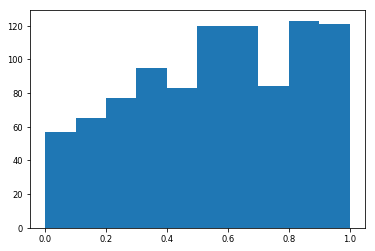

In [394]:
plt.hist(var_pval, bins=10);

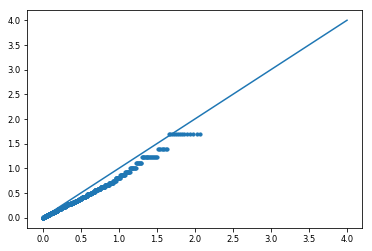

In [395]:
x = np.sort(var_pval)

plt.scatter(
    -np.log10(np.linspace(0, 1, x.shape[0])), 
    -np.log10(x), s=10)

plt.plot([0, 4], [0, 4])

In [791]:
x = np.log(mean_diff.reshape(-1))
y = np.log(var_diff.reshape(-1))
cond = np.isfinite(x) & np.isfinite(y)

In [792]:
stats.spearmanr(x[cond], y[cond])

SpearmanrResult(correlation=-0.06995633237253612, pvalue=0.022048437271494848)

In [700]:
# stats.spearmanr(np.log(mean_diff.reshape(-1)), ))

SyntaxError: invalid syntax (<ipython-input-700-270de557c445>, line 1)

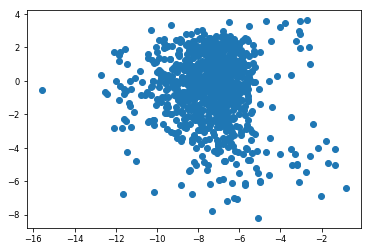

In [701]:
plt.scatter(np.log(mean_diff), np.log(var_diff))

In [365]:
(var_diff > 0).mean()

0.5003915343915344

In [401]:
imp.reload(estimator)

<module 'estimator' from '/home/ssm-user/Github/scrna-parameter-estimation/scmemo/estimator.py'>

In [ ]:
np.unique(size_factor).shape

In [433]:
data = test_adata.X[:, 0].toarray()
counts = np.ones((data.shape[0], 1))
sf = size_factor.reshape(-1, 1)
inv_sf = 1/sf
inv_sf_sq = inv_sf**2

In [478]:
demeaned = ((data*inv_sf)-(data*inv_sf).mean())*sf
estimator._poisson_1d(
    (demeaned, counts),
    test_adata.X[:, 0].shape[0],
    (inv_sf, inv_sf_sq))

[array([0.]), array([45.83317422]), array([45.83317422])]

In [480]:
alpha = (demeaned**2/sf**2).mean()
beta = (demeaned/sf**2).mean()

In [482]:
np.roots([alpha, -beta, -1])

array([-0.14966997,  0.14627124])

In [483]:
devared = demeaned*np.roots([alpha, -beta, -1])[1]

In [484]:
estimator._poisson_1d(
    (devared, counts),
    test_adata.X[:, 0].shape[0],
    (inv_sf, inv_sf_sq))

[array([0.]), array([1.]), array([1.])]